<a href="https://colab.research.google.com/github/bbchen33/Machine-Learning/blob/master/python-machine-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download file from website using wget

In [1]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2019-10-03 01:57:44--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  73.4MB/s    in 1.1s    

2019-10-03 01:57:45 (73.4 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [4]:
!ls

aclImdb  aclImdb_v1.tar.gz  sample_data


In [5]:
!tar -zxf aclImdb_v1.tar.gz

^C


In [7]:
!pip install pyprind
import pyprind
import pandas as pd
import os

In [8]:
basepath = './aclImdb'

labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], ignore_index=True)
            pbar.update()
df.columns = ['review', 'sentiment']

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:57


Examine data structure, missing values, distribution...

In [18]:
df.head()
df.sentiment.isnull().sum()
df.review.isnull().sum()

0

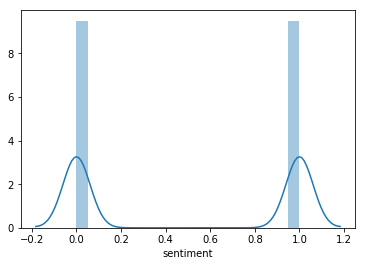

In [20]:
import seaborn as sns
sns.distplot(df.sentiment)

Wordcloud can demonstrate the most commonly used words



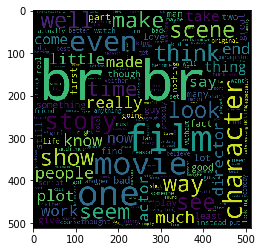

In [86]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
key_words0 = ' '.join(list(df[df.sentiment == 0]['review']))
kw0 = WordCloud(width = 512, height = 512).generate(key_words0)
plt.imshow(kw0)

br is actually from html <br> so that needs to be removed. 

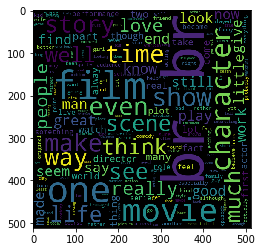

In [87]:
key_words1 = ' '.join(list(df[df.sentiment == 1]['review']))
kw1 = WordCloud(width = 512, height = 512).generate(key_words1)
plt.imshow(kw1)

In [67]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


process the raw text that may contain random symbols and "stopwords" that don't have meanings like "a" or "the"

In [0]:
import re

def process(text):
  text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
  stemmer = SnowballStemmer('english')
  words = ""
  words = [stemmer.stem(w) for w in text]
  text = " ".join(words)
  text = re.sub('<(.*)>', '', text) ## (.*) is wildcard
  
  return text

Because the first half of the data is all 0 and the second half is 1, it's better to shuffle the data first before splitting it into train and test sets

In [97]:
shuffled_df = df.sample(frac = 1, random_state = 0)
print(shuffled_df.head())

                                                  review  sentiment
11841  While both this movie and the signature car ch...          1
19602  'Rise of the Footsoldier' follows the unrelent...          0
45519  ***SPOILERS*** Like some evil Tinkers-to-Evers...          0
25747  "Pet Sematary" is an adaptation from the Steph...          1
42642  What's this? A Canadian produced zombie flick ...          0


In [0]:
reduced_df = shuffled_df[0:1000]

In [100]:
reduced_df['review'] = reduced_df['review'].apply(process)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer('english')
X = vectorizer.fit_transform(reduced_df.review).toarray()
X_train, X_test = X[:750], X[750:]
y_train, y_test = reduced_df.sentiment[:750], reduced_df.sentiment[750:]

In [123]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
print(clf.get_params().keys()) 

dict_keys(['priors', 'var_smoothing'])


In [0]:
import numpy as np
param_range = np.logspace(-15, -9, 7)
param_grid_Gau = [{'var_smoothing':param_range}]


In [0]:
gs = GridSearchCV(estimator = clf,
		 param_grid = param_grid_Gau,
		 scoring = 'accuracy',
		 cv = 5,
		 n_jobs = -1)
gs = gs.fit(X_train, y_train)

In [138]:
print(gs.best_params_)
print(gs.best_score_)

{'var_smoothing': 1e-15}
0.628


Naive Bayes trained with 1000 data did not yield good accuracy. Needs to try a different ML method or improve the learning with more data